# Decision Trees

Decision trees are useful and powerful algorithms for classifying and regressing data. It works on recursive partitioning which will be shown algorithmically in this notebook. Though most of the the time, Sci-Kit Learn can be used to implement this machine learning method simply, it is useful to take a look at the inner workings of these algorithms. This notebook will first introduce a decision tree from scratch. It will then show an example using SK Learn.

## Decision Tree From Scratch Using HMEQ Data

Firstly, we will go through a decision tree made from scratch. The following code is based on the material originally created by Sebastian Mantey for the Iris Dataset whose GitHub is here: https://github.com/SebastianMantey/Decision-Tree-from-Scratch. You can also search his video on YouTube. The code has been adapted to this course's format and fit to HMEQ Dataset.

### Load Relevant Libraries & Data

The first decision tree will be coded from scratch using only pandas and NumPy. There are faster ways to do this using Sci-Kit Learn which is a l

In [1]:
import numpy as np
import pandas as pd
from pprint import pprint

In [2]:
filename = 'https://github.com/Humboldt-WI/bads/blob/master/data/hmeq_modeling.csv?raw=true'
df = pd.read_csv(filename, header = 0, index_col = 0) # import file with header and index as first row and column respectively

In [3]:
df.head() #inspect data to make sure it looks correct

,BAD,LOAN,MORTDUE,VALUE,YOJ,CLAGE,NINQ,CLNO,DEBTINC,DEROGzero,REASON_HomeImp,REASON_IsMissing,JOB_Office,JOB_Other,JOB_ProfExe,JOB_Sales,JOB_Self,DELINQcat_1,DELINQcat_1+
index,,,,,,,,,,,,,,,,,,,
0,True,-1.832283,-1.295882,-1.335526,0.266788,-1.075278,-0.065054,-1.297476,0.137456,True,1,0,0,1,0,0,0,0,0
1,True,-1.810666,-0.013474,-0.672699,-0.236615,-0.723092,-0.826792,-0.756608,0.137456,True,1,0,0,1,0,0,0,0,1
2,True,-1.789048,-1.654549,-1.839275,-0.668103,-0.368769,-0.065054,-1.189302,0.137456,True,1,0,0,1,0,0,0,0,0
3,True,-1.789048,-0.159552,-0.202559,-0.236615,-0.061033,-0.065054,-0.107566,0.137456,True,0,1,0,1,0,0,0,0,0
4,False,-1.767431,0.791699,0.311107,-0.811933,-1.088528,-0.826792,-0.756608,0.137456,True,1,0,1,0,0,0,0,0,0


In [4]:
X = df.drop(['BAD'], axis=1) #code the variables in the most standard way for your usage
y = df[['BAD']]

X.head() #inspect that variables were correctly separated

,LOAN,MORTDUE,VALUE,YOJ,CLAGE,NINQ,CLNO,DEBTINC,DEROGzero,REASON_HomeImp,REASON_IsMissing,JOB_Office,JOB_Other,JOB_ProfExe,JOB_Sales,JOB_Self,DELINQcat_1,DELINQcat_1+
index,,,,,,,,,,,,,,,,,,
0,-1.832283,-1.295882,-1.335526,0.266788,-1.075278,-0.065054,-1.297476,0.137456,True,1,0,0,1,0,0,0,0,0
1,-1.810666,-0.013474,-0.672699,-0.236615,-0.723092,-0.826792,-0.756608,0.137456,True,1,0,0,1,0,0,0,0,1
2,-1.789048,-1.654549,-1.839275,-0.668103,-0.368769,-0.065054,-1.189302,0.137456,True,1,0,0,1,0,0,0,0,0
3,-1.789048,-0.159552,-0.202559,-0.236615,-0.061033,-0.065054,-0.107566,0.137456,True,0,1,0,1,0,0,0,0,0
4,-1.767431,0.791699,0.311107,-0.811933,-1.088528,-0.826792,-0.756608,0.137456,True,1,0,1,0,0,0,0,0,0


In [5]:
y.head()

,BAD
index,
0,True
1,True
2,True
3,True
4,False


In [6]:
print(type(X), type(y), X.shape, y.shape) # double check that types and dimensions are correct before proceeding

<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'> (5960, 18) (5960, 1)


### Helper Functions for the Tree

Decision trees work by recursively partitioning data which means:

Many potential ways to split the data are calculated (eg. we are going to go through all unique values of each column and finding the midpoint between sequential values). For each potential split, we evaluate whether the target variable has more homogeneity in each leaf. This is done by calculating 'impurity' of the parent node and comparing it with the sum of the impurity of the child nodes. There are three major impurity functions: entropy, gini and misclassification. We will be using entropy in our example. The split which yields the lowest impurity is chosen and the process is repeated for the new nodes (this is recursion). 

The method of choosing the split which yields the lowest impurity is called the greedy search method. The following functions will help the decision tree implement greedy search tactics on the data. The algorithm stops either when purity in each node is reached or when it has reached a maximum depth (max amount of recursions we allow) specified in our function.

Many functions for the tree are not found in Python packages and it is cleaner to write them out first then put them together in our main algorithm. Each function below does a specific action which will be used in our final tree function at the end.

In [7]:
def check_purity(y):
    
    'checks if a leaf node is perfectly pure, in other words, if the leaf node contains only one class'
    
    unique_classes = np.unique(y) #count number of classes in section of data

    if len(unique_classes) == 1: #check if the node is pure
        return True
    else:
        return False

In [8]:
def classify_data(y):
    
    'classifies data according to the majority class of each leaf'
    
    unique_classes, counts_unique_classes = np.unique(y, return_counts=True)
    #returns classes and no. of obs per class

    index = counts_unique_classes.argmax() #index of class with most obs
    classification = unique_classes[index] #class chosen for classification which is class with most obs
    
    return classification

In [9]:
def get_potential_splits(X):
    
    'first, takes every unique value of every feature in the feature space, then finds the midpoint between each value'
    
    potential_splits = {}
    _, n_columns = X.shape #don't need rows, we choose the column to split on
    # only need second value of .shape which is columns
    
    for column_index in range(n_columns):
        potential_splits[column_index] = [] 
        values = X[:, column_index] 
        unique_values = np.unique(values) #get all unique values in each column

        for index in range(len(unique_values)): #all unique feature values
            if index != 0: #skip first value, we need the difference between next values
                current_value = unique_values[index]
                previous_value = unique_values[index - 1] #find a value and the next smallest value
                potential_split = (current_value + previous_value) / 2 #find difference between the two as a potential split
                
                #consider all values which lie between two values as a potential split
                
                potential_splits[column_index].append(potential_split)
    
    return potential_splits

In [10]:
def split_data(X, y, split_column, split_value):
    
    'splits data based on specific value, will yield both a split for the features X and target y'
    
    split_column_values = X[:, split_column]

    X_below = X[split_column_values <= split_value] #partitions data according to split values from previous functions
    X_above = X[split_column_values >  split_value]
    
    y_below = y[split_column_values <= split_value]
    y_above = y[split_column_values >  split_value]
    
    return X_below, X_above, y_below, y_above

In [11]:
def calculate_entropy(y):
    
    'calculates entropy for each partition of data'
    
    _, counts = np.unique(y, return_counts=True) #we only need the counts of each class, _ is a placeholder

    probabilities = counts / counts.sum() #probability of each class
    entropy = sum(probabilities * -np.log2(probabilities)) #could replace with Gini impurity or misclassification
     
    return entropy

In [12]:
def calculate_overall_entropy(y_below, y_above): 
    
    'calculates the total entropy after each split'
       
    n = len(y_below) + len(y_above)
    p_data_below = len(y_below) / n
    p_data_above = len(y_above) / n

    overall_entropy =  (p_data_below * calculate_entropy(y_below)
                      + p_data_above * calculate_entropy(y_above))
    
    return overall_entropy

In [13]:
def determine_best_split(X, y, potential_splits):
    
    'selects which split lowered entropy the most'
    
    overall_entropy = 9999 #set arbitrarily high, the function will loop over and replace this with lower impurity values
    for column_index in potential_splits:
        for value in potential_splits[column_index]:
            X_below, X_above, y_below, y_above = split_data(X, y, split_column=column_index, split_value=value)
            current_overall_entropy = calculate_overall_entropy(y_below, y_above)
            
            #goes through each potential split and only updates if it lowers entropy

            if current_overall_entropy <= overall_entropy: 
                overall_entropy = current_overall_entropy #updates only if lower entropy split found, in the ned this is greedy search
                best_split_column = column_index
                best_split_value = value
    
    return best_split_column, best_split_value

### The Main Algorithm

The tree will now implement the helper functions and display the decision which yielded the best split if printed.

In [14]:
def decision_tree_algorithm(X, y, counter=0, min_samples=2, max_depth=5): 
    
    # data preparation
    if counter == 0: # counter tells us how deep the tree is, this is before the tree is initiated
        global COLUMN_HEADERS
        COLUMN_HEADERS = X.columns
        X = X.values #change all to NumPy array for faster calculations
        y = y.values
    else:
        data = X #if we have started the tree, X should already be a NumPy array from the code above 
    
    # base cases
    if (check_purity(y)) or (len(X) < min_samples) or (counter == max_depth):
        classification = classify_data(y)
        
        return classification
    
    # recursive part
    else:    
        counter += 1 #tells us how deep the tree is

        # helper functions 
        potential_splits = get_potential_splits(X) #check for all possible splits
        best_split_column, best_split_value = determine_best_split(X, y, potential_splits) #select best split based on entropy
        X_below, X_above, y_below, y_above = split_data(X, y, best_split_column, best_split_value) #execute best split
        
        # code to explain decisions made by tree to users
        feature_name = COLUMN_HEADERS[best_split_column]
        question = "{} <= {}".format(feature_name, best_split_value) #initiate explanation of split
        sub_tree = {question: []}
        
        # pull answers from tree
        yes_answer = decision_tree_algorithm(X_below, y_below, counter, min_samples, max_depth)
        no_answer = decision_tree_algorithm(X_above, y_above, counter, min_samples, max_depth)
        
        # ensure explanation actually shows useful information
        if yes_answer == no_answer: #if decisions are the same, only display one
            sub_tree = yes_answer
        else:
            sub_tree[question].append(yes_answer)
            sub_tree[question].append(no_answer)
        
        return sub_tree

### Grow First Tree

Test the tree and display the decisions with a shallow depth.

In [15]:
tree = decision_tree_algorithm(X, y, max_depth=2)

#### Structure of the First Tree

In [16]:
pprint(tree)

{'DEBTINC <= 0.13253751764464605': [False,
                                    {'DEBTINC <= 0.137471043429223': [True,
                                                                      False]}]}


In [17]:
tree.values()

dict_values([[False, {'DEBTINC <= 0.137471043429223': [True, False]}]])

The first node in the tree asks the question:

DEBTINC <= 0.13253751764464605

If this is true, the tree will predict BAD as false.

If this is false, the tree will ask a second question:

DEBTINC <= 0.137471043429223

If true, the tree will predict BAD is true. If false, the tree will predict BAD is false.

#### Classification Example from First Tree

Let's take an example and see how the tree classifies it.

In [18]:
example = df.iloc[2] #take a random observation
example

BAD                      True
LOAN                 -1.78905
MORTDUE              -1.65455
VALUE                -1.83928
YOJ                 -0.668103
CLAGE               -0.368769
NINQ               -0.0650545
CLNO                  -1.1893
DEBTINC              0.137456
DEROGzero                True
REASON_HomeImp              1
REASON_IsMissing            0
JOB_Office                  0
JOB_Other                   1
JOB_ProfExe                 0
JOB_Sales                   0
JOB_Self                    0
DELINQcat_1                 0
DELINQcat_1+                0
Name: 2, dtype: object

In [19]:
def classify_example(example, tree):
    question = list(tree.keys())[0] #checks what is the next data split
    feature_name, comparison_operator, value = question.split() #splits question into elements

    # ask question
    if example[feature_name] <= float(value): # checks key element for split
        answer = tree[question][0] # selects yes answer
    else:
        answer = tree[question][1] # selects no answer

    # base case
    if not isinstance(answer, dict): # if answer is not a dictionary, we have reached a decision
        return answer # display prediction
    
    # recursive part
    else:
        residual_tree = answer # continue if another dictionary is reached
        return classify_example(example, residual_tree)

In [20]:
classify_example(example, tree)

True

In [21]:
y.iloc[2]

BAD    True
Name: 2, dtype: bool

The classification for this one instance above is correct, how well does this tree do for the rest of the data points?

#### Predictions and Accuracy from First Tree

In [22]:
predictions = X.apply(classify_example, axis=1, args=(tree,))

In [23]:
error = np.mean(np.vstack(predictions) == np.array(y))

error

0.851006711409396

The tree is able to classify a good proportion of the test set well even with only a depth of 2.

### Higher Depth in Tree

Test the tree and display the decisions with a higher depth to see if accuracy changed.

In [24]:
tree_deep = decision_tree_algorithm(X, y, max_depth=5)

In [25]:
predictions_deep = pd.DataFrame(X.apply(classify_example, axis=1, args=(tree_deep,)))

In [26]:
error_deep = np.mean(np.array(predictions_deep) == np.array(y))

error_deep

0.8897651006711409

The performance of the tree is even better with this depth. However, as we continue to increase depth, there will come a point where the accuracy decreases as the tree internalizes noise from the data. This is called overfitting and weakens the tree's ability to classify unseen observations. Thus, the tree can be deepened only until the test set accuracy begins decreasing.

## Decision Trees with Sci-Kit Learn

As mentioned, the package Ski-Kit Learn has prebuilt functions which avoid coding most algorithms by scratch. Now armed with the knowledge of the inner workings of the decision tree, it should be easier to understand what this algorithm is trying to achieve.

In [27]:
from sklearn import tree

clf = tree.DecisionTreeClassifier(criterion="entropy", min_samples_split=2, max_depth=2) #keep tree at a low depth

dt_shallow = clf.fit(X, y)

In [28]:
pred_dt_shallow = dt_shallow.predict(X)

In [29]:
pred_dt_shallow[0:5]

array([ True,  True,  True,  True,  True])

In [30]:
classify_correct_shallow = pred_dt_shallow == y.iloc[:,0]
accuracy_shallow = classify_correct_shallow.mean()


accuracy_shallow

0.851006711409396

[Text(167.4, 181.2, 'X[7] <= 0.133\nentropy = 0.721\nsamples = 5960\nvalue = [4771, 1189]'),
 Text(83.7, 108.72, 'X[17] <= 0.5\nentropy = 0.315\nsamples = 2341\nvalue = [2208, 133]'),
 Text(41.85, 36.23999999999998, 'entropy = 0.261\nsamples = 2215\nvalue = [2117, 98]'),
 Text(125.55000000000001, 36.23999999999998, 'entropy = 0.852\nsamples = 126\nvalue = [91, 35]'),
 Text(251.10000000000002, 108.72, 'X[7] <= 0.137\nentropy = 0.871\nsamples = 3619\nvalue = [2563, 1056]'),
 Text(209.25, 36.23999999999998, 'entropy = 0.959\nsamples = 1273\nvalue = [486, 787]'),
 Text(292.95, 36.23999999999998, 'entropy = 0.514\nsamples = 2346\nvalue = [2077, 269]')]

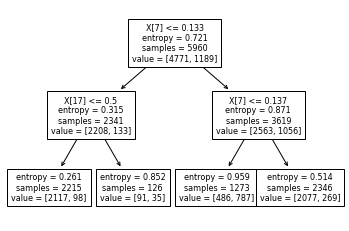

In [35]:
tree.plot_tree(dt_shallow, fontsize=8)

### SK Learn Tree with No Limit on Depth

If we remove the maximum depth parameter, the algorithm will go as far as it can until all nodes are pure.

In [32]:
clf = tree.DecisionTreeClassifier(criterion='entropy', min_samples_split=2)

dt_deep = clf.fit(X, y)

pred_dt_deep = dt_deep.predict(X)

In [33]:
pred_dt_deep[0:5]

array([ True,  True,  True,  True, False])

In [34]:
classify_correct_deep = pred_dt_deep == y.iloc[:,0]
accuracy_deep = classify_correct_deep.mean()

accuracy_deep

1.0

While this seems great at first glance, what is the problem here? What does this mean for new data that we encounter whose idiosyncracies may be slightly different than the data we used to train the model?